In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from extract_load import multiple_csv_to_dict_df
from preprocessing import combine_dataframes


#from contractions import CONTRACTION_MAP
from re import compile, IGNORECASE, DOTALL, sub, escape
from string import punctuation
import numpy as np
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from wordcloud import WordCloud, STOPWORDS

import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
import time
import random
random.seed(2018)

In [2]:
"""
Created on Mon Aug 01 01:11:02 2016
@author: DIP
"""

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [3]:
#d1 = pd.read_csv("./data/Medicare_National_HCPCS_Aggregate_Summary_Table_CY2015.csv")
#d1 = d1[(d1.iloc[:,2] == 'N ')] # & (d1.iloc[:,3] == 'O ')
#d1.head(3)


path = "./data"
dict_df = multiple_csv_to_dict_df(path)

key_filter = ['2014','2015','2016']
dict_df = { your_key: dict_df[your_key] for your_key in key_filter }


d1 = combine_dataframes(dict_df)
#d1[(d1.iloc[:,2] == 'N ')] # & (d1.iloc[:,3] == 'O ')
d1.head(5)
d1.info()

#path = "./data"
#dict_df = multiple_csv_to_dict_df(path)
#d1 = dict_df['2015']
#d1[(d1.iloc[:,2] == 'N ')] # & (d1.iloc[:,3] == 'O ')
#d1.head(5)
#d1.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38342 entries, 0 to 38341
Data columns (total 13 columns):
index                                                       38342 non-null int64
HCPCS Code                                                  38342 non-null object
HCPCS Description                                           38342 non-null object
HCPCS Drug Indicator                                        38342 non-null object
Place of Service                                            38342 non-null object
Number of Providers                                         38342 non-null int64
Number of Services                                          38342 non-null int64
Number of Unique Beneficiary/Provider Interactions          38342 non-null int64
Number of Distinct Medicare Beneficiary/Per Day Services    38342 non-null int64
Average Submitted Charge Amount                             38342 non-null float64
Average Medicare Allowed Amount                             38342 non-null 

In [4]:
stopword_list = stopwords.words('english') # nltk.download()
wnl = WordNetLemmatizer()

In [5]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

In [6]:
d2 = d1.loc[:,["HCPCS Description","Place of Service","Average Medicare Standardized Payment Amount"]]
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('  ',' ', x))
d2.head(20)
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38342 entries, 0 to 38341
Data columns (total 3 columns):
HCPCS Description                               38342 non-null object
Place of Service                                38342 non-null object
Average Medicare Standardized Payment Amount    38342 non-null float64
dtypes: float64(1), object(2)
memory usage: 898.7+ KB


In [7]:
d2.iloc[:,2].quantile(.25)

42.8625

In [8]:
d2 = d2[(d2.iloc[:,2] < d2.iloc[:,2].quantile(.8))&(d2.iloc[:,2] > d2.iloc[:,2].quantile(.2))]

In [9]:
d2.iloc[:,2].min()

28.62

(array([693., 608., 583., 687., 459., 541., 498., 458., 485., 474., 390.,
        432., 433., 399., 389., 349., 377., 293., 312., 304., 292., 290.,
        268., 264., 250., 259., 243., 265., 261., 271., 263., 273., 237.,
        213., 226., 216., 221., 223., 212., 223., 199., 185., 170., 201.,
        215., 200., 185., 195., 182., 162., 164., 165., 186., 173., 160.,
        166., 168., 180., 166., 158., 163., 147., 158., 163., 145., 140.,
        171., 168., 157., 157., 132., 173., 134., 149., 144., 152., 136.,
        139., 121., 130., 128., 124., 139., 140., 132., 127., 131., 124.,
        106., 116., 118., 111., 112.,  89., 106.,  95.,  96., 117., 106.,
         92.]),
 array([ 28.62  ,  33.2591,  37.8982,  42.5373,  47.1764,  51.8155,
         56.4546,  61.0937,  65.7328,  70.3719,  75.011 ,  79.6501,
         84.2892,  88.9283,  93.5674,  98.2065, 102.8456, 107.4847,
        112.1238, 116.7629, 121.402 , 126.0411, 130.6802, 135.3193,
        139.9584, 144.5975, 149.2366, 153.8757

C:\Users\jvaug_000\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


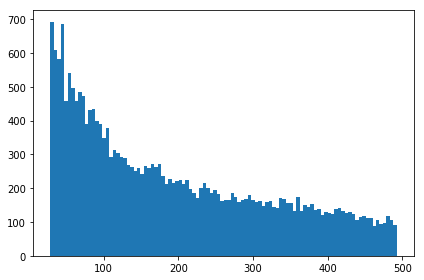

In [10]:
fig, axs = plt.subplots(1,1, sharey=True, tight_layout=True)
axs.hist(d2.iloc[:,2], bins=100)

In [11]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word.strip() for word in tokens]
    return tokens

In [12]:
d3 = d2.copy()
d3.iloc[:,0] = d2.iloc[:,0].apply(lambda x: tokenize_text(x))
d3.head(3)


,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
0,"[anesthesia, for, procedure, on, salivary, gla...",F,188.93
1,"[anesthesia, for, procedure, to, repair, lip, ...",F,138.11
2,"[anesthesia, for, procedure, on, eyelid]",F,122.21


In [13]:
def expand_contractions(text, contraction_mapping):
    contractions_pattern = compile('({})'.format('|'.join(contraction_mapping.keys())),flags=IGNORECASE | DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = sub("'", "", expanded_text)
    return expanded_text

In [14]:
d4 = d2.copy()
d4.iloc[:,0] = d4.iloc[:,0].apply(lambda x: expand_contractions(x,CONTRACTION_MAP))
d4.head(3)

,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
0,anesthesia for procedure on salivary gland wit...,F,188.93
1,anesthesia for procedure to repair lip defect ...,F,138.11
2,anesthesia for procedure on eyelid,F,122.21


In [15]:
def remove_stopwords(text):
    words = tokenize_text(text)
    filtered_tokens = [word for word in words if word not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [16]:
d5 = d4.copy()
d5.iloc[:,0] = d4.iloc[:,0].apply(lambda x: remove_stopwords(x))
d5.head(3)

,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
0,anesthesia procedure salivary gland biopsy,F,188.93
1,anesthesia procedure repair lip defect present...,F,138.11
2,anesthesia procedure eyelid,F,122.21


In [17]:
def remove_special_characters(text):
    words = tokenize_text(text)
    pattern = compile('[{}]'.format(escape(punctuation)))
    filtered_words = filter(None, [pattern.sub('', word) for word in words])
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [18]:
d6 = d5.copy()
d6.iloc[:,0] = d5.iloc[:,0].apply(lambda x: remove_special_characters(x))
d6.head(3)

,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
0,anesthesia procedure salivary gland biopsy,F,188.93
1,anesthesia procedure repair lip defect present...,F,138.11
2,anesthesia procedure eyelid,F,122.21


In [19]:
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []    
    for text in corpus:
        #text = expand_contractions(text, CONTRACTION_MAP)
#        text = lemmatize_text(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
    return normalized_corpus

In [20]:
d7 = normalize_corpus(d2.iloc[:,0], tokenize=False)
d7[1]

'anesthesia procedure repair lip defect present birth'

In [21]:
#stopwords = set(STOPWORDS)
#wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016,width=1000, height=500).generate(" ".join([i for i in d2.iloc[:,0]]))
#plt.figure( figsize=(20,10), facecolor='k')
#plt.imshow(wordcloud)
#plt.axis("off")
#https://datascienceplus.com/twitter-analysis-with-python/

In [22]:
train, validate = train_test_split(d2, test_size=.10, random_state=0)
train, validate = train.copy(), validate.copy()

In [23]:
train.head(3)

,HCPCS Description,Place of Service,Average Medicare Standardized Payment Amount
17904,injection of hemorrhoids,O,188.21
4611,drainage of abscess cyst or blood accumulation...,F,179.92
23029,dialysis procedure including one evaluation,F,67.82


In [24]:
train['ind'] = range(train.iloc[:,0].count())
train = train.set_index(['ind'])
train = pd.concat([train, pd.get_dummies(train['Place of Service'], drop_first= True)], axis = 1)
train = train.drop(['Place of Service'], axis = 1)

In [25]:
train_text_norm = normalize_corpus(train.iloc[:,0], tokenize=False)
train_target = train['Average Medicare Standardized Payment Amount']

In [26]:
train_text_norm[1]

'drainage abscess cyst blood accumulation jaw bone'

In [27]:
train_target.head()

ind
0    188.21
1    179.92
2     67.82
3    162.63
4    250.26
Name: Average Medicare Standardized Payment Amount, dtype: float64

In [28]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),stop_words="english", max_df=.99, min_df=.01)
train_count_vectorized = count_vectorizer.fit_transform(train_text_norm)

In [29]:
# What does the data look like?
# Get the array and show the data train_count_vectorized
train_count_vectorized_array = train_count_vectorized.toarray()
print("Here is the array shape \n", train_count_vectorized_array.shape, "\n")
# Show the features that were used
features = count_vectorizer.get_feature_names()
print("Here are the features extracted \n", features, "\n")
# Show a snip of the data
print("Here is what goes into the model \n", 
      pd.DataFrame(data=train_count_vectorized_array[0:10, :], columns=features).head(3), "\n")

Here is the array shape 
 (20701, 140) 

Here are the features extracted 
 ['abdominal', 'abnormal', 'abscess', 'accessed', 'agent', 'analysis', 'andor', 'anesthesia', 'ankle', 'application', 'arm', 'arms', 'artery', 'aspiration', 'beneath', 'biopsy', 'bladder', 'blood', 'body', 'bone', 'bones', 'bowel', 'brain', 'breast', 'broken', 'canal', 'catheter', 'cavity', 'centimeters', 'chest', 'closed', 'contrast', 'ct', 'cyst', 'destruction', 'device', 'diagnostic', 'dilation', 'drainage', 'duct', 'ears', 'elbow', 'endoscope', 'esophagus', 'evaluation', 'examination', 'external', 'eye', 'eyelids', 'face', 'feet', 'finger', 'flow', 'fluid', 'foot', 'forearm', 'foreign', 'genitals', 'graft', 'growth', 'growths', 'guidance', 'hand', 'hands', 'heart', 'imaging', 'incision', 'including', 'infusion', 'injection', 'insertion', 'interpretation', 'joint', 'kidney', 'knee', 'large', 'leg', 'legs', 'lower', 'lung', 'manipulation', 'measurement', 'medicine', 'mg', 'minutes', 'mouth', 'mri', 'multiple', 

In [30]:
train_count_vectorized_df = pd.DataFrame(data=train_count_vectorized_array, columns=features)
train_count_vectorized_df['Place_O'] = train.iloc[:,2]

In [31]:
# Cross-validate Predict
model = RandomForestRegressor(n_estimators=10, max_depth=5)
predict = cross_val_predict(model, train_count_vectorized_df, train_target)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]

In [32]:
# Analyze accuracy
print("Accuracy: %.2f percent" % (accuracy_score(train_target_processed, predict_processed) * 100))
# Analyze Root Mean Squared Error
print("RMSE: %.2f " % np.sqrt(mean_squared_error(train_target, predict)))

Accuracy: 0.24 percent
RMSE: 114.67 


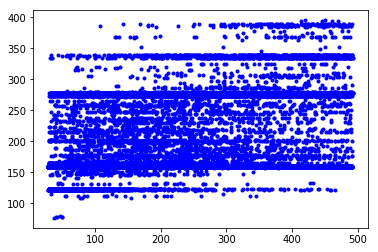

In [33]:
%matplotlib inline
plt.plot(train_target, predict, 'b.')

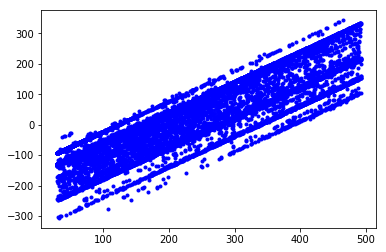

In [34]:
plt.plot(train_target,(train_target - predict), 'b.')

In [35]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words="english", max_df=.99, min_df=.01)
train_tfidf_vectorized = tfidf_vectorizer.fit_transform(train_text_norm)

In [36]:
# What does the data look like?
# Get the array and show the data train_count_vectorized
train_tfidf_vectorized_array = train_tfidf_vectorized.toarray()
print("Here is the array shape \n", train_tfidf_vectorized_array.shape, "\n")
# Show the features that were used
features = tfidf_vectorizer.get_feature_names()
print("Here are the features extracted \n", features, "\n")
# Show a snip of the data
print("Here is what goes into the model \n", 
      pd.DataFrame(data=train_tfidf_vectorized_array[:10, :], columns=features).head(3), "\n")

Here is the array shape 
 (20701, 140) 

Here are the features extracted 
 ['abdominal', 'abnormal', 'abscess', 'accessed', 'agent', 'analysis', 'andor', 'anesthesia', 'ankle', 'application', 'arm', 'arms', 'artery', 'aspiration', 'beneath', 'biopsy', 'bladder', 'blood', 'body', 'bone', 'bones', 'bowel', 'brain', 'breast', 'broken', 'canal', 'catheter', 'cavity', 'centimeters', 'chest', 'closed', 'contrast', 'ct', 'cyst', 'destruction', 'device', 'diagnostic', 'dilation', 'drainage', 'duct', 'ears', 'elbow', 'endoscope', 'esophagus', 'evaluation', 'examination', 'external', 'eye', 'eyelids', 'face', 'feet', 'finger', 'flow', 'fluid', 'foot', 'forearm', 'foreign', 'genitals', 'graft', 'growth', 'growths', 'guidance', 'hand', 'hands', 'heart', 'imaging', 'incision', 'including', 'infusion', 'injection', 'insertion', 'interpretation', 'joint', 'kidney', 'knee', 'large', 'leg', 'legs', 'lower', 'lung', 'manipulation', 'measurement', 'medicine', 'mg', 'minutes', 'mouth', 'mri', 'multiple', 

In [37]:
train_tfidf_vectorized_df = pd.DataFrame(data=train_tfidf_vectorized_array, columns=features)
train_tfidf_vectorized_df['Place_O'] = train.iloc[:,2]

In [38]:
# Cross-validate Predict
model = RandomForestRegressor(n_estimators=10, max_depth=5)
predict = cross_val_predict(model, train_tfidf_vectorized_df, train_target)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]

In [39]:
predict_processed

[116,
 234,
 160,
 160,
 183,
 160,
 321,
 169,
 160,
 160,
 160,
 160,
 273,
 160,
 160,
 160,
 286,
 160,
 160,
 160,
 160,
 160,
 174,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 234,
 169,
 160,
 160,
 160,
 160,
 160,
 161,
 160,
 160,
 160,
 237,
 273,
 273,
 160,
 116,
 273,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 116,
 116,
 160,
 339,
 160,
 160,
 160,
 160,
 160,
 279,
 160,
 160,
 160,
 160,
 116,
 160,
 273,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 339,
 160,
 160,
 273,
 160,
 160,
 273,
 169,
 234,
 160,
 160,
 339,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 169,
 160,
 160,
 116,
 160,
 160,
 160,
 160,
 242,
 160,
 160,
 174,
 116,
 160,
 160,
 160,
 160,
 160,
 116,
 160,
 160,
 160,
 160,
 160,
 174,
 234,
 116,
 160,
 286,
 160,
 265,
 273,
 273,
 286,
 242,
 174,
 116,
 160,
 160,
 160,
 273,
 273,
 160,
 160,
 288,
 160,
 160,
 160,
 339,
 242,
 243,
 234,
 234,
 234,
 160,
 160,
 273,
 160,
 286,
 160,
 160,
 160,
 160,
 160,
 160

In [40]:
# Analyze accuracy
print("Accuracy: %.2f percent" % (accuracy_score(train_target_processed, predict_processed) * 100))
# Analyze Root Mean Squared Error
print("RMSE: %.2f " % np.sqrt(mean_squared_error(train_target, predict)))

Accuracy: 0.26 percent
RMSE: 114.88 


In [41]:
# Tuning parameters using a pipeline

pipeline = Pipeline([("vect", TfidfVectorizer(max_features=10000)),
                     ("model", RandomForestRegressor(random_state=0))])

parameters = {
    "vect__ngram_range": [(1, 3)],  # <- Notice (1, 2) vs (1, 1)
    "vect__max_df": [1.],
    "vect__min_df": [.04],
    "model__n_estimators": [50],
    "model__max_depth": [30]
}

grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3)

start = time.time()
grid.fit(train_text_norm, train_target)
stop = time.time()
print("total time: ", stop-start)

total time:  13.455498218536377


In [42]:
# Analyze results
pprint.pprint(grid.best_params_)

# Generate predictions
model = grid.best_estimator_
predict = cross_val_predict(model, train_text_norm, train_target, cv=5, n_jobs=3)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]

# Analyze accuracy
print("Accuracy: %.2f percent" % (accuracy_score(train_target_processed, predict_processed) * 100))
# Analyze Root Mean Squared Error
print("RMSE: %.2f " % np.sqrt(mean_squared_error(train_target, predict)))

{'model__max_depth': 30,
 'model__n_estimators': 50,
 'vect__max_df': 1.0,
 'vect__min_df': 0.04,
 'vect__ngram_range': (1, 3)}
Accuracy: 0.33 percent
RMSE: 112.60 


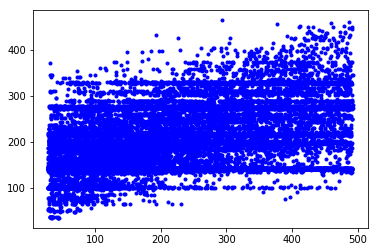

In [43]:
plt.plot(train_target, predict, 'b.')

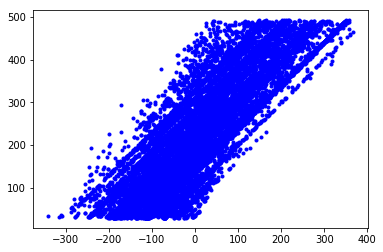

In [44]:
plt.plot((train_target - predict), train_target, 'b.')

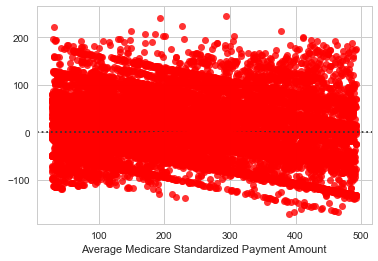

In [45]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# Make an example dataset with y ~ x
rs = np.random.RandomState(7)
x = train_target
y = predict

# Plot the residuals after fitting a linear model
sns.residplot(x, y, lowess=True, color="r")